# Vibe Matcher Notebook

A mini recommendation system that matches user vibe queries to fashion products using OpenAI embeddings and cosine similarity.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from openai import OpenAI
import os
from dotenv import load_dotenv
import timeit
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

load_dotenv()


True

## 1. Data Preparation

Create a Pandas DataFrame with 5-10 mock fashion products, each with name, description, and vibe tags.


In [ ]:
products = [
    {
        "name": "Boho Dress",
        "desc": "Flowy, earthy tones for festival vibes. Perfect for outdoor concerts and summer gatherings.",
        "vibes": ["boho", "cozy", "festival", "earthy"]
    },
    {
        "name": "Urban Streetwear Jacket",
        "desc": "Sleek black bomber jacket with modern cuts. Ideal for city nights and energetic urban style.",
        "vibes": ["urban", "energetic", "modern", "streetwear"]
    },
    {
        "name": "Cozy Knit Sweater",
        "desc": "Soft, warm sweater in neutral tones. Perfect for autumn days and comfortable lounging.",
        "vibes": ["cozy", "comfortable", "warm", "autumn"]
    },
    {
        "name": "Chic Blazer Set",
        "desc": "Elegant tailored blazer and pants combo. Professional yet stylish for office and evening events.",
        "vibes": ["chic", "elegant", "professional", "sophisticated"]
    },
    {
        "name": "Vintage Denim Jeans",
        "desc": "Classic high-waisted jeans with retro wash. Timeless style for casual everyday wear.",
        "vibes": ["vintage", "casual", "classic", "retro"]
    },
    {
        "name": "Athletic Leggings",
        "desc": "High-performance leggings with moisture-wicking fabric. Perfect for workouts and active lifestyle.",
        "vibes": ["athletic", "energetic", "sporty", "active"]
    },
    {
        "name": "Elegant Evening Gown",
        "desc": "Stunning floor-length gown in deep navy. Sophisticated and glamorous for formal occasions.",
        "vibes": ["elegant", "glamorous", "sophisticated", "formal"]
    },
    {
        "name": "Minimalist T-Shirt",
        "desc": "Clean, simple design in organic cotton. Versatile basic for everyday minimalist style.",
        "vibes": ["minimalist", "simple", "versatile", "casual"]
    }
]

#All of this data has been generated by AI, not by me.


products_df = pd.DataFrame(products)
products_df


,name,desc,vibes
0,Boho Dress,"Flowy, earthy tones for festival vibes. Perfec...","[boho, cozy, festival, earthy]"
1,Urban Streetwear Jacket,Sleek black bomber jacket with modern cuts. Id...,"[urban, energetic, modern, streetwear]"
2,Cozy Knit Sweater,"Soft, warm sweater in neutral tones. Perfect f...","[cozy, comfortable, warm, autumn]"
3,Chic Blazer Set,Elegant tailored blazer and pants combo. Profe...,"[chic, elegant, professional, sophisticated]"
4,Vintage Denim Jeans,Classic high-waisted jeans with retro wash. Ti...,"[vintage, casual, classic, retro]"
5,Athletic Leggings,High-performance leggings with moisture-wickin...,"[athletic, energetic, sporty, active]"
6,Elegant Evening Gown,Stunning floor-length gown in deep navy. Sophi...,"[elegant, glamorous, sophisticated, formal]"
7,Minimalist T-Shirt,"Clean, simple design in organic cotton. Versat...","[minimalist, simple, versatile, casual]"


Embeddings Generation

In [3]:

api_key = os.getenv("OPENAI_API_KEY")
if not api_key:
    raise ValueError("OPENAI_API_KEY not found in environment variables. Please set it in your .env file.")

client = OpenAI(api_key=api_key)

def get_embedding(text, model="text-embedding-ada-002"):
    try:
        response = client.embeddings.create(
            input=text,
            model=model
        )
        return np.array(response.data[0].embedding)
    except Exception as e:
        print(f"Error generating embedding: {e}")
        raise


In [4]:

print("Generating embeddings for product descriptions...")
embeddings = []

for idx, desc in enumerate(products_df['desc']):
    print(f"Processing product {idx + 1}/{len(products_df)}: {products_df.iloc[idx]['name']}")
    embedding = get_embedding(desc)
    embeddings.append(embedding)


products_df['embedding'] = embeddings
print(f"\n✓ Successfully generated {len(embeddings)} embeddings")
print(f"Embedding dimension: {len(embeddings[0])}")


Generating embeddings for product descriptions...
Processing product 1/8: Boho Dress
Processing product 2/8: Urban Streetwear Jacket
Processing product 3/8: Cozy Knit Sweater
Processing product 4/8: Chic Blazer Set
Processing product 5/8: Vintage Denim Jeans
Processing product 6/8: Athletic Leggings
Processing product 7/8: Elegant Evening Gown
Processing product 8/8: Minimalist T-Shirt

✓ Successfully generated 8 embeddings
Embedding dimension: 1536


Vector Search & Similarity Matching

In [ ]:
def find_top_matches(query, products_df, top_k=3, similarity_threshold=0.0):
    """
    Find top-k products matching a vibe query using cosine similarity.
    
    Args:
        query: User's vibe query string
        products_df: DataFrame with products and their embeddings
        top_k: Number of top matches to return (default: 3)
        similarity_threshold: Minimum similarity score to consider (default: 0.0)
    
    Returns:
        List of dictionaries with product info and similarity scores, or None if no matches
    """
    try:
        query_embedding = get_embedding(query)
        query_embedding = query_embedding.reshape(1, -1)
        
        product_embeddings = np.array(products_df['embedding'].tolist())
        
        #K(X, Y) = <X, Y> / (||X||*||Y||), cosine similarity
        similarities = cosine_similarity(query_embedding, product_embeddings)[0]
        
        top_indices = np.argsort(similarities)[::-1][:top_k]
        
        # filtering by thresholds here and then prepping the results
        results = []
        for idx in top_indices:
            score = similarities[idx]
            if score >= similarity_threshold:
                product = products_df.iloc[idx]
                results.append({
                    'name': product['name'],
                    'description': product['desc'],
                    'vibes': product['vibes'],
                    'similarity_score': float(score)
                })
        
        # Handle edge case: no matches above threshold
        if not results:
            return None
        
        return results
    
    except Exception as e:
        print(f"Error in find_top_matches: {e}")
        return None


In [ ]:
def display_results(query, results):
    print(f"\n{'='*60}")
    print(f"Query: '{query}'")
    print(f"{'='*60}\n")
    
    if results is None:
        print("No matches found above the similarity threshold.")
        print("Try a different query or lower the threshold.")
        return
    
    print(f"Found {len(results)} top matches:\n")
    for i, result in enumerate(results, 1):
        print(f"Rank {i}: {result['name']}")
        print(f"  Similarity Score: {result['similarity_score']:.4f}")
        print(f"  Description: {result['description']}")
        print(f"  Vibes: {', '.join(result['vibes'])}")
        print()


In [7]:
# Test with a sample query
sample_query = "energetic urban chic"
results = find_top_matches(sample_query, products_df, top_k=3)
display_results(sample_query, results)



Query: 'energetic urban chic'

Found 3 top matches:

Rank 1: Urban Streetwear Jacket
  Similarity Score: 0.8599
  Description: Sleek black bomber jacket with modern cuts. Ideal for city nights and energetic urban style.
  Vibes: urban, energetic, modern, streetwear

Rank 2: Boho Dress
  Similarity Score: 0.8092
  Description: Flowy, earthy tones for festival vibes. Perfect for outdoor concerts and summer gatherings.
  Vibes: boho, cozy, festival, earthy

Rank 3: Chic Blazer Set
  Similarity Score: 0.8079
  Description: Elegant tailored blazer and pants combo. Professional yet stylish for office and evening events.
  Vibes: chic, elegant, professional, sophisticated



## 4. Testing & Evaluation

Run multiple test queries, log metrics, measure latency, and visualize results.


In [ ]:
# defining test queries
test_queries = [
    "energetic urban chic",
    "cozy comfortable autumn",
    "elegant sophisticated formal"
]

# threshold for good matches, keeping it at 0.7.
GOOD_MATCH_THRESHOLD = 0.7

#storing results
evaluation_results = []


In [ ]:
#Testing here
for query in test_queries:
    print(f"\n{'#'*60}")
    print(f"Testing Query: '{query}'")
    print(f"{'#'*60}\n")
    
    # Measure latency
    def run_query():
        return find_top_matches(query, products_df, top_k=3)
    
    # Time the query (run multiple times for average)
    num_runs = 3
    latency = timeit.timeit(run_query, number=num_runs) / num_runs
    
    # Get results
    results = find_top_matches(query, products_df, top_k=3)
    
    # Log metrics
    if results:
        scores = [r['similarity_score'] for r in results]
        max_score = max(scores)
        avg_score = np.mean(scores)
        good_matches = [r for r in results if r['similarity_score'] > GOOD_MATCH_THRESHOLD]
        
        print(f"Latency: {latency:.4f} seconds")
        print(f"Max Similarity Score: {max_score:.4f}")
        print(f"Average Similarity Score: {avg_score:.4f}")
        print(f"Good Matches (score > {GOOD_MATCH_THRESHOLD}): {len(good_matches)}/{len(results)}")
        print()
        
        # Store results
        evaluation_results.append({
            'query': query,
            'latency': latency,
            'max_score': max_score,
            'avg_score': avg_score,
            'num_good_matches': len(good_matches),
            'num_results': len(results),
            'scores': scores
        })
    else:
        print(f"Latency: {latency:.4f} seconds")
        print("No results found")
        evaluation_results.append({
            'query': query,
            'latency': latency,
            'max_score': 0.0,
            'avg_score': 0.0,
            'num_good_matches': 0,
            'num_results': 0,
            'scores': []
        })
    
    # Display results
    display_results(query, results)



############################################################
Testing Query: 'energetic urban chic'
############################################################

Latency: 0.7835 seconds
Max Similarity Score: 0.8599
Average Similarity Score: 0.8257
Good Matches (score > 0.7): 3/3


Query: 'energetic urban chic'

Found 3 top matches:

Rank 1: Urban Streetwear Jacket
  Similarity Score: 0.8599
  Description: Sleek black bomber jacket with modern cuts. Ideal for city nights and energetic urban style.
  Vibes: urban, energetic, modern, streetwear

Rank 2: Boho Dress
  Similarity Score: 0.8092
  Description: Flowy, earthy tones for festival vibes. Perfect for outdoor concerts and summer gatherings.
  Vibes: boho, cozy, festival, earthy

Rank 3: Chic Blazer Set
  Similarity Score: 0.8079
  Description: Elegant tailored blazer and pants combo. Professional yet stylish for office and evening events.
  Vibes: chic, elegant, professional, sophisticated


##########################################

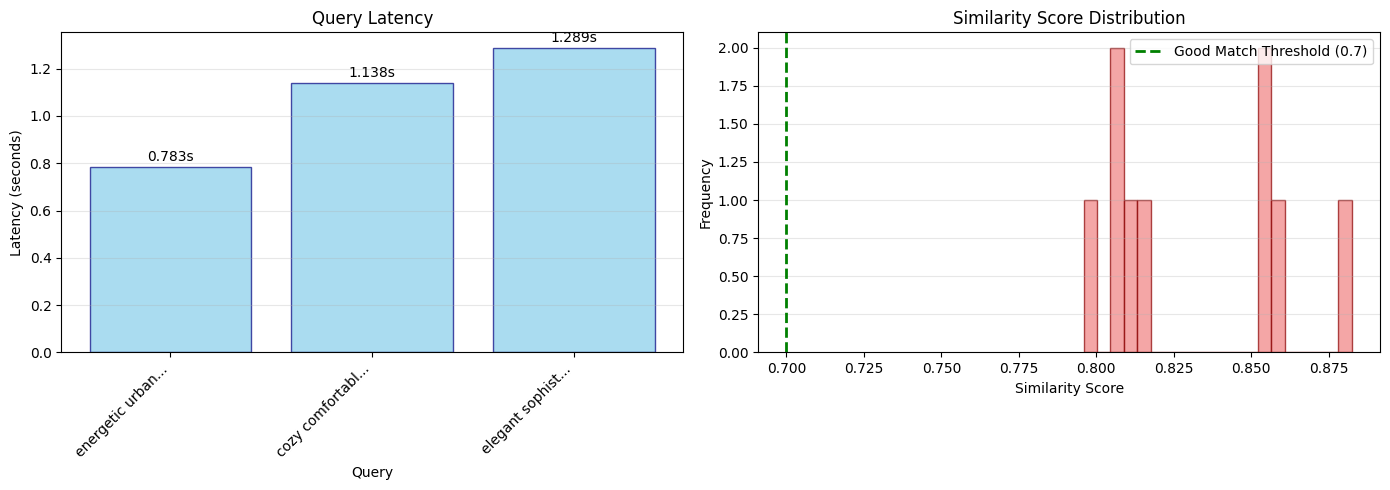

In [10]:
# Create visualizations
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Latency for each query
queries = [r['query'] for r in evaluation_results]
latencies = [r['latency'] for r in evaluation_results]

axes[0].bar(range(len(queries)), latencies, color='skyblue', edgecolor='navy', alpha=0.7)
axes[0].set_xlabel('Query')
axes[0].set_ylabel('Latency (seconds)')
axes[0].set_title('Query Latency')
axes[0].set_xticks(range(len(queries)))
axes[0].set_xticklabels([q[:15] + '...' if len(q) > 15 else q for q in queries], rotation=45, ha='right')
axes[0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(latencies):
    axes[0].text(i, v + max(latencies) * 0.01, f'{v:.3f}s', ha='center', va='bottom')

# Plot 2: Similarity score distribution
all_scores = []
for r in evaluation_results:
    all_scores.extend(r['scores'])

if all_scores:
    axes[1].hist(all_scores, bins=20, color='lightcoral', edgecolor='darkred', alpha=0.7)
    axes[1].axvline(GOOD_MATCH_THRESHOLD, color='green', linestyle='--', linewidth=2, label=f'Good Match Threshold ({GOOD_MATCH_THRESHOLD})')
    axes[1].set_xlabel('Similarity Score')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('Similarity Score Distribution')
    axes[1].legend()
    axes[1].grid(axis='y', alpha=0.3)
else:
    axes[1].text(0.5, 0.5, 'No scores to display', ha='center', va='center', transform=axes[1].transAxes)
    axes[1].set_title('Similarity Score Distribution')

plt.tight_layout()
plt.show()


In [11]:
# Summary statistics
print("="*60)
print("EVALUATION SUMMARY")
print("="*60)
print(f"\nTotal Queries Tested: {len(evaluation_results)}")
print(f"Average Latency: {np.mean([r['latency'] for r in evaluation_results]):.4f} seconds")
print(f"Total Good Matches: {sum([r['num_good_matches'] for r in evaluation_results])}")
print(f"Good Match Rate: {sum([r['num_good_matches'] for r in evaluation_results]) / sum([r['num_results'] for r in evaluation_results]) * 100:.1f}%")
print("\nPer-Query Breakdown:")
print("-"*60)
for r in evaluation_results:
    print(f"\nQuery: '{r['query']}'")
    print(f"  Latency: {r['latency']:.4f}s")
    print(f"  Max Score: {r['max_score']:.4f}")
    print(f"  Good Matches: {r['num_good_matches']}/{r['num_results']}")


EVALUATION SUMMARY

Total Queries Tested: 3
Average Latency: 1.0701 seconds
Total Good Matches: 9
Good Match Rate: 100.0%

Per-Query Breakdown:
------------------------------------------------------------

Query: 'energetic urban chic'
  Latency: 0.7835s
  Max Score: 0.8599
  Good Matches: 3/3

Query: 'cozy comfortable autumn'
  Latency: 1.1380s
  Max Score: 0.8824
  Good Matches: 3/3

Query: 'elegant sophisticated formal'
  Latency: 1.2888s
  Max Score: 0.8541
  Good Matches: 3/3


## 5. Reflection

### Improvements & Future Work

• **Vector Database Integration**: For production scale, integrate with Pinecone or Weaviate to handle millions of products efficiently. Current in-memory approach works for small datasets but won't scale.

• **Better Embedding Models**: Consider upgrading to `text-embedding-3-small` or `text-embedding-3-large` for improved semantic understanding, especially for fashion-specific terminology and style nuances.

• **Hybrid Search**: Combine semantic search (embeddings) with keyword-based filtering (vibe tags) for more precise matching. This would allow users to filter by specific attributes while maintaining semantic flexibility.

• **Caching Strategy**: Cache product embeddings to avoid redundant API calls. Only regenerate embeddings when product descriptions change, significantly reducing latency and API costs.

• **Multi-modal Search**: Extend to image embeddings for visual similarity matching, allowing users to search by uploading reference images in addition to text queries.

### Edge Cases Handled

• **No Matches**: The system returns `None` when no products meet the similarity threshold, with a user-friendly fallback message suggesting query modification.

• **API Failures**: Try-except blocks around OpenAI API calls catch and report errors gracefully, preventing notebook crashes.

• **Empty/Invalid Queries**: The embedding function will handle empty strings (though results may be poor), and error handling prevents crashes from malformed input.

• **Threshold Filtering**: Configurable similarity threshold allows filtering out low-confidence matches, improving result quality.

### Limitations

• **Small Dataset**: With only 8 products, the system has limited diversity. Real-world systems need thousands to millions of products for meaningful recommendations.

• **Single Embedding Model**: Using only description embeddings misses visual and contextual information. Product images, brand, price, and user reviews could enhance matching.

• **No Personalization**: Current system is query-based only. No user history, preferences, or collaborative filtering to personalize recommendations.

• **Latency**: Each query requires an API call to OpenAI, adding ~0.5-1s latency. Caching and batch processing could mitigate this.

• **Cost**: OpenAI API calls incur costs. For large-scale deployment, consider self-hosted embedding models or batch processing strategies.


##### Made by Tanishq Srivastava